In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import numpy as np
from scipy.spatial import distance
import math
import statistics

In [2]:
#filter specific file names
luminance = 'Light_Luminance_3.500_secs_001_reduced_matched.csv'
red = 'star_Light_Red_30_secs_001_reduced_matched.csv'
green = 'star_Light_Green_30_secs_001_reduced_matched.csv'
blue = 'star_Light_Blue_30_secs_001_reduced_matched.csv'

#set current filter
ref_csv_name = luminance
current_filter = 'Luminance'

#define file read path and the file list, excluding the first file
read_path = Path(f'./RZ Cep/All_RZ_Cep/2023_11_10/RZ_Cep/CSVs/Matched Stars/{current_filter}')
file_list = [f for f in os.listdir(read_path)if f.endswith(".csv") and f != ref_csv_name]

In [3]:
#set up a dictionary of valid star names 
valid_stars = None

#set up a list which will contain dictionaries of stars and their associated magnitudes, date/times and exposure times
star_properties = []
to_delete = []

#enumerate adds an index to each file in the list
for i, fname in enumerate(file_list):
    #read in the dataframe
    df = pd.read_csv(read_path / fname)
    #add an empty dictionary to star_properties
    star_properties.append({})
    
    #if the dictionary valid_stars has not been created, create it
    #assumes all stars in the first dataframe (image 2) appear only once, which they do
    if valid_stars is None:
        valid_stars = {}
        #iterate through row and associated index in the dataframe, iterrows allows for this
        for idx, row in df.iterrows():
            #extract star name from dataframe
            star_name = row['star_id']
            #checks for valid magnitudes (i.e. not from negative fluxes)
            if row['instrumental_mag'] != np.nan:
                #set up new row in the star_properties dictionary (index i to be associated with dataframe/image i) to save
                #the star name and its associated image number, magnitude, date/time and exposure time
                star_properties[i][star_name] = {
                    'img_number': i + 1,
                    'instrumental_mag': float(row['instrumental_mag']),
                    'mag_error': float(row['mag_error']),
                    'date_time': str(row['date_time']),
                    'exp_time': float(row['exp_time'])
                }
                #add new row to valid_stars dictionary to save the position values
                valid_stars[star_name] = (row['x_center'], row['y_center'])
                
    #if valid_stars has already been created, so for any other dataframe that is not the first one:            
    else:
        #counts how many times each star's name has occured in the dataframe
        vcounts = df['star_id'].value_counts()
        #iterates through star names and positions saved in the valid_stars dictionary
        for star_name, (xpos, ypos) in valid_stars.items():
            #run if the star is in the dataframe, otherwise the star will not be considered this loop iteration
            if star_name in vcounts:
                #if the star appears only once in the dataframe, run this
                if vcounts[star_name] == 1:   
                    #all properties must be type converted first here, as they output as a pd.string when using df.loc
                    mag = float(df.loc[df['star_id'] == star_name]['instrumental_mag'])
                    err = float(df.loc[df['star_id'] == star_name]['mag_error'])
                    #time needs to be output as a string, using just str() didn't eliminate the associated index
                    #first, it is converted to a list and the zeroth index value (the only value) converted into a string, 
                    #which gets around this issue
                    time = str(list(df.loc[df['star_id'] == star_name]['date_time'])[0])
                    img_exptime = float(df.loc[df['star_id'] == star_name]['exp_time'])
                    if mag != np.nan and not math.isnan(mag):
                        #properties are saved to the dictionary, added to the section corresponding to that star
                        star_properties[i][star_name] = {
                                'img_number': i + 1,
                                'instrumental_mag': mag,
                                'mag_error': err,
                                'date_time': time,
                                'exp_time': img_exptime
                            }
                    else:
                        to_delete.append(star_name)
                #if the star appears more or less than once, run this
                else:
                    #save the previous position to a variable
                    prev_pos = (xpos, ypos)
                    #set up an arbitrary minimum distance
                    min_dist = np.inf
                    #iterate through all the duplicate instances of the star in the dataframe
                    for idx, row in df[df['star_id'] == star_name].iterrows():
                        #test if the distance between the position of this star instance is less than either the arbitrary
                        #distance or the other points associated with other instances of the star in the dataframe.
                        #if the new distance is less than the min distance for other star instances, the current instance
                        #is more likely to be the correct star and not a mislabeled one
                        if row["instrumental_mag"] != np.nan and not math.isnan(row["instrumental_mag"]):
                            if distance.euclidean(prev_pos, (row['x_center'], row['y_center'])) < min_dist:
                                #update the new minimum point distance
                                min_dist = distance.euclidean(prev_pos, (row['x_center'], row['y_center']))
                                #save star properties to dictionary
                                star_properties[i][star_name] = {
                                        'img_number': i + 1,
                                        'instrumental_mag': float(row['instrumental_mag']),
                                        'mag_error': float(row['mag_error']),
                                        'date_time': str(row['date_time']),
                                        'exp_time': float(row['exp_time'])
                                    }
                                #overwrite star position in valid_stars                          
                                valid_stars[star_name] = (row['x_center'], row['y_center'])
                        #if the star is not in the image, add it a list of star names to be removed (first condition)
                        else:
                            to_delete.append(star_name)
            #if the star is not in the image, add it to a list of stars to be deleted (second condition)
            else:
                to_delete.append(star_name)
        
        #iterate over star names saved in list of stars to be deleted
        for star_name in to_delete:
        #delete saved position values for misidentification purposes
            del valid_stars[star_name]
            #delete all previous iterations of the star saved in the loop
            for idx, previous_iters in enumerate(star_properties):
                if star_name in previous_iters:
                    del star_properties[idx][star_name]
        
        #reset the list of stars to delete, so stars are not removed twice
        to_delete = []
                        
                        
                
#print(valid_stars)
#print(star_properties)

#print dictionary properties for RZ Cep
#for star_num in star_properties:
#    print(star_num['V* RZ Cep'])
    
#print all star names saved in star_properties dictionary
for star_name in star_properties[0]:
    print(star_name)

2MASS J22420892+6508103
TYC 4273-149-1
TYC 4273-876-1
TYC 4273-673-1
TYC 4273-343-1
Gaia DR3 2212402667093547008
NVSS J224054+645420
IRAS 22364+6432
2MASS J22405245+6505370
TYC 4273-884-1
Gaia DR3 2212396207462733568
TYC 4273-858-1
UCAC4 774-052682
TYC 4273-668-1
TYC 4273-1351-1
UCAC4 776-050859
TYC 4273-922-1
Gaia DR2 2211583698432680064
2MASS J22365043+6456254
V* RZ Cep
LSPM J2241+6501
IRAS 22404+6450
Gaia DR3 2211625479874273536


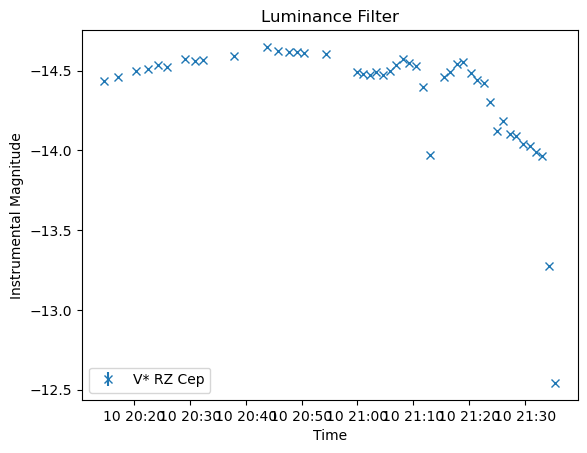

In [4]:
#plot example stars
img_num_star = []
inst_mag_star = []
mag_err = []
date_time_star = []
exp_time_star = []
corrected_mag = []
corrected_err = []

star_name = 'V* RZ Cep'

#funky lookin stars:
#Gaia DR2 2211583698432680064 - drops off a lot
#TYC 4273-858-1 - very noisy, looks like it jumps between stars
#UCAC4 774-052682 - curves downward in some places
#IRAS 22364+6432 - also curves down, missing lots of data
#TYC 4273-900-1 - curves downward in two places
#UCAC4 776-050859 - six data points


for obs_data in star_properties:
    if star_name in obs_data:
        img_num_star.append(obs_data[star_name]['img_number'])
        inst_mag_star.append(obs_data[star_name]['instrumental_mag'])
        mag_err.append(abs(obs_data[star_name]['mag_error']))
        date_time_star.append(obs_data[star_name]['date_time'])
        exp_time_star.append(obs_data[star_name]['exp_time'])
        
        corrected_mag.append(obs_data[star_name]['instrumental_mag'] + 2.5 * np.log10(obs_data[star_name]['exp_time']))
        
date_time_star = pd.to_datetime(date_time_star)
#print(mag_err)

plt.errorbar(date_time_star, corrected_mag, yerr=mag_err, marker='x', ls='None', label=star_name)
plt.title('Luminance Filter')
plt.xlabel('Time')
plt.ylabel('Instrumental Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

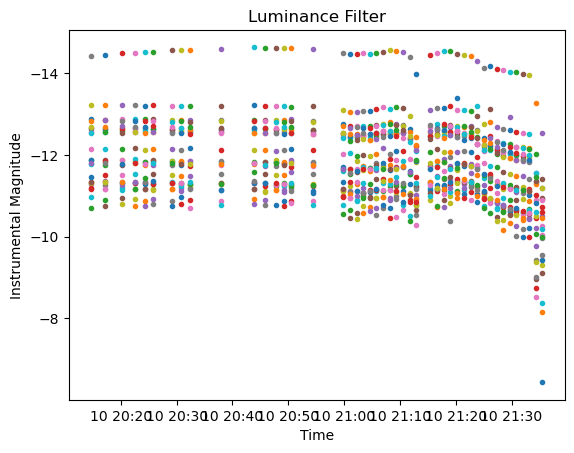

In [5]:
#plot all stars
for obs_data in range(len(star_properties)):
    for star_name in star_properties[obs_data]:
        img_num = []
        inst_mag = []
        date_time = []
        exp_time = []
        mag_err = []
        corrected_mag = []
        
        img_num.append(star_properties[obs_data][star_name]['img_number'])
        inst_mag.append(star_properties[obs_data][star_name]['instrumental_mag'])
        mag_err.append(abs(star_properties[obs_data][star_name]['mag_error']))
        date_time.append(star_properties[obs_data][star_name]['date_time'])
        exp_time.append(star_properties[obs_data][star_name]['exp_time'])
        
        corrected_mag.append(star_properties[obs_data][star_name]['instrumental_mag'] +
                             2.5 * np.log10(star_properties[obs_data][star_name]['exp_time']))
        
        date_time = pd.to_datetime(date_time)
        plt.errorbar(date_time, corrected_mag, yerr=mag_err, marker='.', ls='None', label=star_name)
        del img_num, inst_mag, mag_err, date_time, exp_time, corrected_mag
    
plt.title('Luminance Filter')
plt.xlabel('Time')
plt.ylabel('Instrumental Magnitude')
plt.gca().invert_yaxis()
#plt.legend()
plt.show()

In [6]:
#define a correction factor function to apply to each star individually
def get_correction_factors(images):
    #set reference point as first image data set
    ref = images[0]
    #set the first correction factor associated with the first image data set to 1
    corr_factors = [1]
    #iterate over all image data sets, excluding the first one
    for image in images[1:]:
        #append the corrected factors array with a correction factor for each image
        corr_factors.append(ref / image)
    #return the correction factors for this star
    return corr_factors


#save list of star names without star of interest
names_without_cep = star_properties[0].keys() - {'V* RZ Cep'}
#set up a new empty dictionary conatining all the star names without rz cep
star_datapoints = {key: [] for key in names_without_cep}
#for each image in the star_properties list of dicts of dicts
for image in star_properties:
    #iterate over the star names without rz cep
    for star_name in names_without_cep:
        #append all the instrumental magnitudes to the new empty dictionary
        star_datapoints[star_name].append(image[star_name]['instrumental_mag'])

#create a list of lists containing all image by image correction factors for each individual star
imgbyimg_factors = [get_correction_factors(val) for key, val in star_datapoints.items()]

#set up list of lists containing the mean and std of each image's correction factors
condensed_correction_factors = [
    [np.mean([row[colnum] for row in imgbyimg_factors]),
        np.std([row[colnum] for row in imgbyimg_factors])] for colnum, _ in enumerate(imgbyimg_factors[0])]
    
print(condensed_correction_factors)
#print(len(condensed_correction_factors))
#first sq bracket changes image, second square bracket changes between mean and standard deviation
#print(condensed_correction_factors[0][1])

[[1.0, 0.0], [1.001764800773916, 0.001981351576053126], [0.998373299654077, 0.014633045683486395], [1.0019101379787225, 0.0024864101716251114], [1.0009054593562043, 0.0023784720219086207], [1.003127172146819, 0.0018573878915567493], [0.9713276992596248, 0.0031099728475356444], [0.9713478723855397, 0.002174382123640689], [0.9713194092362601, 0.002286526460230718], [0.9709616505211073, 0.0018662054618152166], [0.9723662220387443, 0.0024502417081402736], [0.9714745455594691, 0.0018998584971215786], [0.9720111726775834, 0.0019939305296125657], [0.9722761775866027, 0.002530495386634218], [0.9727705533406077, 0.002748412045753759], [0.9725819761333082, 0.0017112835946217792], [1.0120227424801642, 0.004107034387673443], [1.0152517310084144, 0.005342056708497612], [1.0147788209710773, 0.007851026920579344], [1.0130146083248535, 0.004890489934910983], [1.0138966450821387, 0.003663134171146352], [1.0114062180525036, 0.004998459299528846], [1.0072073948077, 0.006462506734172834], [1.0095330506759

In [7]:
#print(star_properties)

#iterate over star_properties to correct all the magnitudes
for image_number, dictionary in enumerate(star_properties):
    #iterate over each star name
    for star_name in dictionary.keys():
        #apply correction factor to each magnitude for each star
        star_properties[image_number][star_name]['instrumental_mag'] *= condensed_correction_factors[image_number][0]
        #star_properties[image_number][star_name]['exp_time'] *= condensed_correction_factors[image_number][0]

print(star_properties)

#no need for a second iteration, as correction factors all come out to approx 1 with std of 2-3 mags smaller

[{'2MASS J22420892+6508103': {'img_number': 1, 'instrumental_mag': -14.58786641169005, 'mag_error': -0.0013126563313348, 'date_time': '2023-11-10T20:43:47.235', 'exp_time': 3.5}, 'TYC 4273-149-1': {'img_number': 1, 'instrumental_mag': -13.131197042419949, 'mag_error': -0.0025673490102245, 'date_time': '2023-11-10T20:43:47.235', 'exp_time': 3.5}, 'TYC 4273-876-1': {'img_number': 1, 'instrumental_mag': -14.228838580350018, 'mag_error': -0.0015486618639207, 'date_time': '2023-11-10T20:43:47.235', 'exp_time': 3.5}, 'TYC 4273-673-1': {'img_number': 1, 'instrumental_mag': -12.686243993300026, 'mag_error': -0.0031511967603228, 'date_time': '2023-11-10T20:43:47.235', 'exp_time': 3.5}, 'TYC 4273-343-1': {'img_number': 1, 'instrumental_mag': -13.174939406254625, 'mag_error': -0.0025161494829738, 'date_time': '2023-11-10T20:43:47.235', 'exp_time': 3.5}, 'Gaia DR3 2212402667093547008': {'img_number': 1, 'instrumental_mag': -12.524024713123527, 'mag_error': -0.0033956223023102, 'date_time': '2023-1

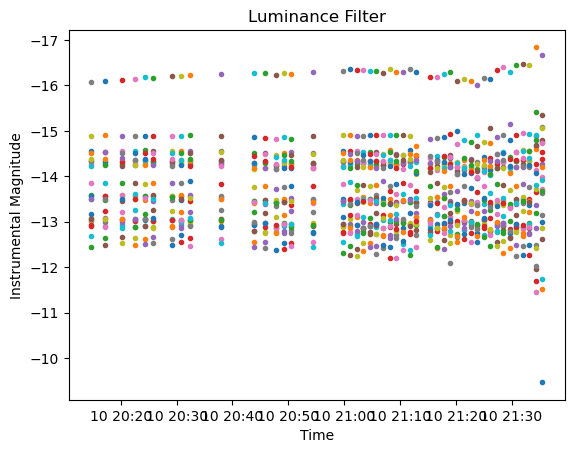

In [8]:
#corr factor changes to -0.5??

#plot all stars
for obs_data in range(len(star_properties)):
    for star_name in star_properties[obs_data]:
        img_num = []
        inst_mag = []
        mag_err = []
        date_time = []
        exp_time = []
        corrected_mag = []
        
        img_num.append(star_properties[obs_data][star_name]['img_number'])
        inst_mag.append(star_properties[obs_data][star_name]['instrumental_mag'])
        mag_err.append(abs(star_properties[obs_data][star_name]['mag_error']))
        date_time.append(star_properties[obs_data][star_name]['date_time'])
        exp_time.append(star_properties[obs_data][star_name]['exp_time'])
        
        corrected_mag.append(star_properties[obs_data][star_name]['instrumental_mag'] -
                             0.5 * np.log10(star_properties[obs_data][star_name]['exp_time']))
        
        date_time = pd.to_datetime(date_time)
        plt.errorbar(date_time, corrected_mag, yerr=mag_err, marker='.', ls='None', label=star_name)
        del img_num, inst_mag, mag_err, date_time, exp_time, corrected_mag
    
plt.title('Luminance Filter')
plt.xlabel('Time')
plt.ylabel('Instrumental Magnitude')
plt.gca().invert_yaxis()
#plt.legend()
plt.show()

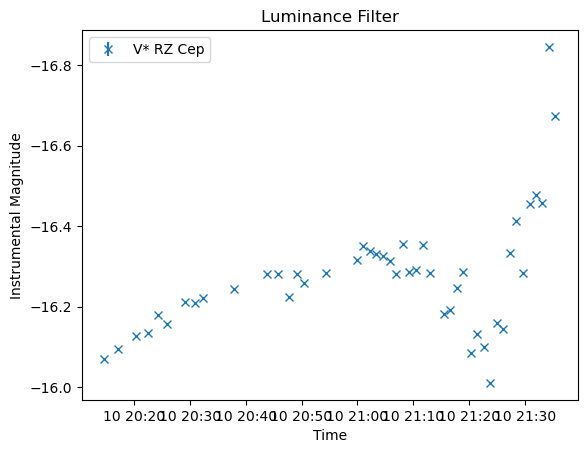

In [9]:
#plot example stars
img_num_star = []
inst_mag_star = []
mag_err_star = []
date_time_star = []
exp_time_star = []
corrected_mag = []

star_name = 'V* RZ Cep'

for obs_data in star_properties:
    if star_name in obs_data:
        img_num_star.append(obs_data[star_name]['img_number'])
        inst_mag_star.append(obs_data[star_name]['instrumental_mag'])
        mag_err_star.append(abs(obs_data[star_name]['mag_error']))
        date_time_star.append(obs_data[star_name]['date_time'])
        exp_time_star.append(obs_data[star_name]['exp_time'])
        
        corrected_mag.append(obs_data[star_name]['instrumental_mag'] - 
                             0.5 * np.log10(obs_data[star_name]['exp_time']))
        
date_time_star = pd.to_datetime(date_time_star)

plt.errorbar(date_time_star, corrected_mag, yerr=mag_err_star, marker='x', ls='None', label=star_name)
plt.title('Luminance Filter')
plt.xlabel('Time')
plt.ylabel('Instrumental Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [10]:
#use ap stats error or sqrt counts

df_curve = pd.DataFrame(data=(corrected_mag, mag_err_star, date_time_star))
df_curve = df_curve.T
df_curve.columns = ['corrected_magnitude', 'magnitude_error', 'date_time']
df_curve

,corrected_magnitude,magnitude_error,date_time
0,-16.280461,0.000682,2023-11-10 20:43:47.235
1,-16.281435,0.000691,2023-11-10 20:45:47.284
2,-16.223082,0.000692,2023-11-10 20:47:44.454
3,-16.282272,0.000691,2023-11-10 20:49:10.517
4,-16.258839,0.000694,2023-11-10 20:50:29.100
5,-16.28489,0.000697,2023-11-10 20:54:28.449
6,-16.07057,0.000629,2023-11-10 20:14:41.115
7,-16.095313,0.000622,2023-11-10 20:17:06.300
8,-16.126629,0.000613,2023-11-10 20:20:16.947
9,-16.134248,0.000609,2023-11-10 20:22:28.615
